#Detecção de face pela webcam com modelo pré-treinado

Realizar a detecção de faces em uma imagem utilizando um modelo pré-treinado do OpenCV. O processo foi dividido em várias etapas:

1. Captura da foto pela webcam: Ao executar o código, um botão de captura é exibido na interface do Colab, permitindo ao usuário tirar a foto. A imagem é então salva no formato JPEG com a qualidade especificada (padrão de 80%). Essa abordagem utiliza a API JavaScript para interagir com a webcam e capturar a imagem, retornando-a para o ambiente Python onde a imagem é salva localmente.

2. Download dos Arquivos do Modelo: Inicialmente, dois arquivos necessários para a detecção foram baixados diretamente da internet: o arquivo deploy.prototxt, que contém a definição da arquitetura da rede neural, e o arquivo res10_300x300_ssd_iter_140000.caffemodel, que possui os pesos do modelo treinado para detecção de faces.

3. Carregamento do Modelo: Após o download, o modelo foi carregado no OpenCV utilizando a função cv2.dnn.readNetFromCaffe. Essa função permite que a rede neural seja configurada com os arquivos baixados, preparando-a para a detecção.

4. Processamento da Imagem: A imagem de entrada foi carregada e redimensionada para uma largura máxima de 400 pixels, mantendo a proporção original. Esse redimensionamento é importante para garantir que o processamento seja mais rápido sem perder a qualidade da detecção. Além disso, a imagem foi convertida para um blob, que é o formato exigido pela rede neural para realizar a detecção.

5. Detecção de Faces: A detecção das faces foi realizada pela rede neural, que analisou a imagem e gerou resultados com as coordenadas das caixas delimitadoras das faces detectadas. Apenas as detecções com uma confiança superior a 50% foram consideradas. Para cada face detectada, foi desenhada uma caixa vermelha ao redor da face e exibida a probabilidade de acerto (confiança) ao lado.



In [ ]:
import imutils #redimencionamento, rotacao
import numpy as np
import cv2 #import OpenCV
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript #webcan leitura
from google.colab.output import eval_js #webcan leitura
from base64 import b64decode #biblioteca para codificar dados binários
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

image_file = take_photo()

<IPython.core.display.Javascript object>

In [ ]:
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    """
    Captura uma foto usando a webcam no Google Colab e salva como arquivo JPEG.

    Parâmetros:
    - filename (str): Nome do arquivo para salvar a foto.
    - quality (float): Qualidade da imagem capturada (entre 0 e 1).

    Retorna:
    - str: Caminho do arquivo salvo.
    """

    # Define o código JavaScript para acessar a webcam e capturar a imagem
    js = Javascript('''
        async function takePhoto(quality) {
            // Cria elementos HTML para a interface de captura
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';  // Botão para capturar a imagem
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';  // Exibe o vídeo no navegador
            const stream = await navigator.mediaDevices.getUserMedia({video: true});  // Solicita acesso à webcam

            document.body.appendChild(div);  // Adiciona a interface à página
            div.appendChild(video);  // Anexa o elemento de vídeo
            video.srcObject = stream;  // Liga o fluxo da webcam ao vídeo
            await video.play();  // Começa a exibir o vídeo ao vivo

            // Ajusta o tamanho do iframe para exibir a interface corretamente no Colab
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Aguarda o clique no botão "Capture" para capturar a imagem
            await new Promise((resolve) => capture.onclick = resolve);

            // Cria um canvas para salvar o frame capturado como uma imagem
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);  // Desenha o frame no canvas

            // Encerra o stream da webcam e remove os elementos da interface
            stream.getVideoTracks()[0].stop();
            div.remove();

            // Retorna a imagem capturada como um data URL no formato JPEG
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    # Exibe o código JavaScript para executar a função takePhoto
    display(js)

    # Avalia a função JavaScript no ambiente do Colab e obtém o data URL da imagem capturada
    data = eval_js(f'takePhoto({quality})')

    # Decodifica o data URL para salvar o arquivo em formato binário
    binary = b64decode(data.split(',')[1])

    # Salva o arquivo JPEG no disco com o nome especificado
    with open(filename, 'wb') as f:
        f.write(binary)

    # Retorna o caminho do arquivo salvo
    return filename

# Captura a foto e salva como 'photo.jpg'
image_file = take_photo()
print(f"Foto salva como {image_file}")


<IPython.core.display.Javascript object>

Foto salva como photo.jpg


In [ ]:
# Baixar os arquivos necessários para o modelo de detecção de faces
# O primeiro arquivo é o protótipo do modelo em Caffe (prototxt), que define a arquitetura da rede
# O segundo arquivo é o modelo treinado, que contém os pesos da rede neural
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# Nome dos arquivos baixados
prototxt = 'deploy.prototxt'  # Arquivo que define a arquitetura do modelo (Caffe deploy file)
model = 'res10_300x300_ssd_iter_140000.caffemodel'  # Arquivo com os pesos treinados

# Carregar o modelo de detecção de faces no OpenCV
# A função `cv2.dnn.readNetFromCaffe` carrega a arquitetura (prototxt) e os pesos (caffemodel)
net = cv2.dnn.readNetFromCaffe(prototxt, model)

# Verificação: exibir mensagem indicando que o modelo foi carregado
print("Modelo de detecção de faces carregado com sucesso!")


--2024-12-16 21:16:09--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2024-12-16 21:16:09 (14.4 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-12-16 21:16:09--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

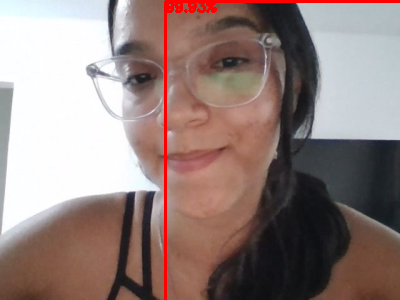

In [ ]:
# Carrega a imagem de entrada
image = cv2.imread(image_file)

# Obtém as dimensões originais da imagem
(h, w) = image.shape[:2]

# Redimensiona a imagem para ter uma largura máxima de 400 pixels (mantendo a proporção)
image = imutils.resize(image, width=400)

# Cria um blob a partir da imagem redimensionada
# O blob é necessário para preparar a imagem para entrada no modelo de detecção
blob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)),  # Redimensiona a imagem para 300x300 pixels
    1.0,                            # Fator de escala
    (300, 300),                     # Tamanho esperado pelo modelo
    (104.0, 177.0, 123.0)           # Subtração média para normalizar os valores
)

# Define o blob como entrada para a rede neural
net.setInput(blob)

# Executa a detecção de faces e retorna as detecções
detections = net.forward()

# Percorre todas as detecções
for i in range(0, detections.shape[2]):

    # Extrai a confiança (probabilidade) associada à detecção
    confidence = detections[0, 0, i, 2]

    # Filtra as detecções com confiança acima de um limite (neste caso, 50%)
    if confidence > 0.5:
        # Calcula as coordenadas da caixa delimitadora da face detectada
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # Desenha a caixa delimitadora ao redor da face detectada
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

        # Adiciona o texto com a probabilidade associada à detecção
        text = "{:.2f}%".format(confidence * 100)  # Formata a confiança como porcentagem
        y = startY - 10 if startY - 10 > 10 else startY + 10  # Ajusta a posição do texto
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# Exibe a imagem resultante com as detecções
cv2_imshow(image)



O modelo, no entanto, não gerou resultados compatíveis com o esperado. Isso pode ser devido à qualidade da imagem de entrada, a configuração do modelo ou outros fatores técnicos que afetam o desempenho da detecção.

#Detecção de Faces com OpenCV
Nesta célula, foi utilizado o OpenCV modelo 'CascadeClassifier' para detectar faces em uma imagem carregada pelo usuário. Após o upload da imagem, o código converte a imagem para escala de cinza e aplica o classificador Haarcascade pré-treinado para detectar faces. Para cada face detectada, é desenhada uma caixa verde ao redor da região da face. Por fim, a imagem resultante é exibida com as caixas delimitadoras das faces detectadas.



Saving 20241215_110843.jpg to 20241215_110843.jpg


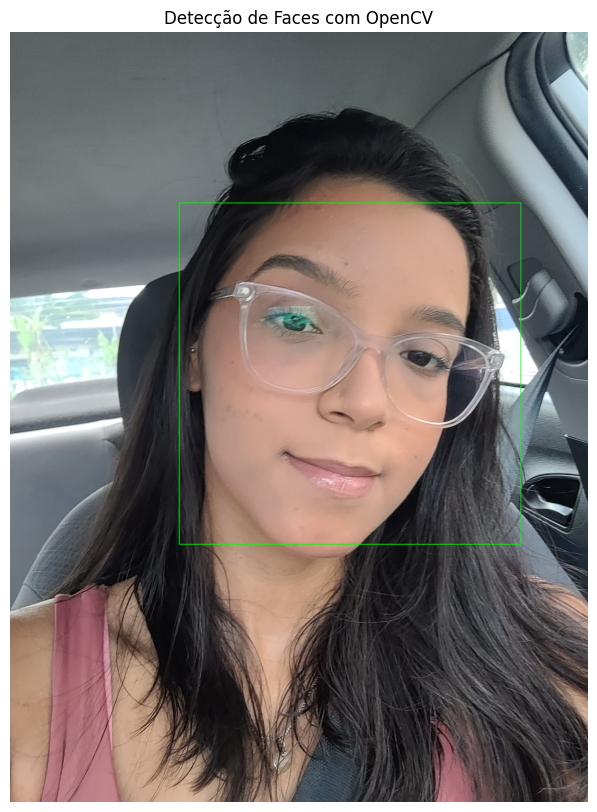

In [ ]:
# Carregar imagem
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Carregar o modelo pré-treinado Haarcascade para detecção de faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Converter a imagem para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detectar faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Desenhar as caixas nas faces detectadas
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Exibir a imagem com os rostos detectados
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detecção de Faces com OpenCV")
plt.show()


#Classificação de Face e Olhos com OpenCV
Foi utilizado o modelo CascadeClassifier do OpenCV para detectar tanto faces quanto olhos em uma imagem. Após carregar a imagem e convertê-la para escala de cinza, o código aplica dois classificadores Haarcascade: um para faces e outro para olhos.

Primeiro, as faces são detectadas e caixas delimitadoras são desenhadas ao redor delas. Em seguida, dentro de cada face detectada, o modelo busca pelos olhos e desenha caixas vermelhas ao redor deles. A imagem resultante é exibida, com as faces e os olhos destacados.

Os resultados mostraram uma boa performance, mas não foram perfeitos, o que pode ser devido a limitações dos classificadores Haarcascade ou a condições específicas da imagem, como iluminação e ângulo.

In [ ]:
# Baixar e carregar os modelos no Colab
!wget -q https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml -O face.xml
!wget -q https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml -O eyes.xml

face_cascade = cv2.CascadeClassifier('face.xml')
eye_cascade = cv2.CascadeClassifier('eyes.xml')

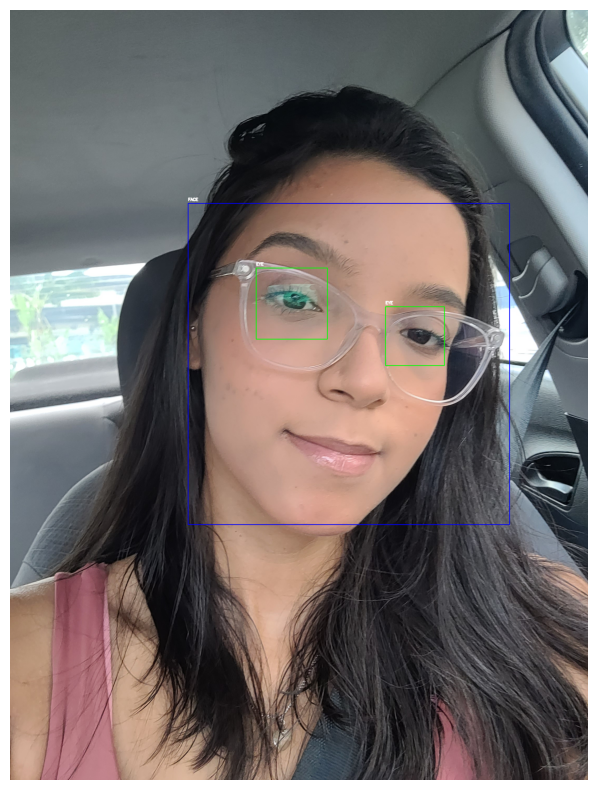

In [ ]:
def process_image(uploaded_file):
  frame = cv2.imread(uploaded_file)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  # Detectar rostos e olhos
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)

  # Adicionar retângulos na imagem original
  for (x, y, w, h) in faces:
      cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
      cv2.putText(frame, 'FACE', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

  for (x, y, w, h) in eyes:
      cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(frame, 'EYE', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

  # Exibir o resultado usando Matplotlib
  plt.figure(figsize=(10, 10))
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
  plt.imshow(frame_rgb)
  plt.axis('off')
  plt.show()

# Carregar uma imagem como exemplo (substitua pelo caminho ou carregue seu próprio arquivo no Colab)
uploaded_file = "/content/20241215_110843.jpg"  # Substitua por outro arquivo carregado no Colab
process_image(uploaded_file)

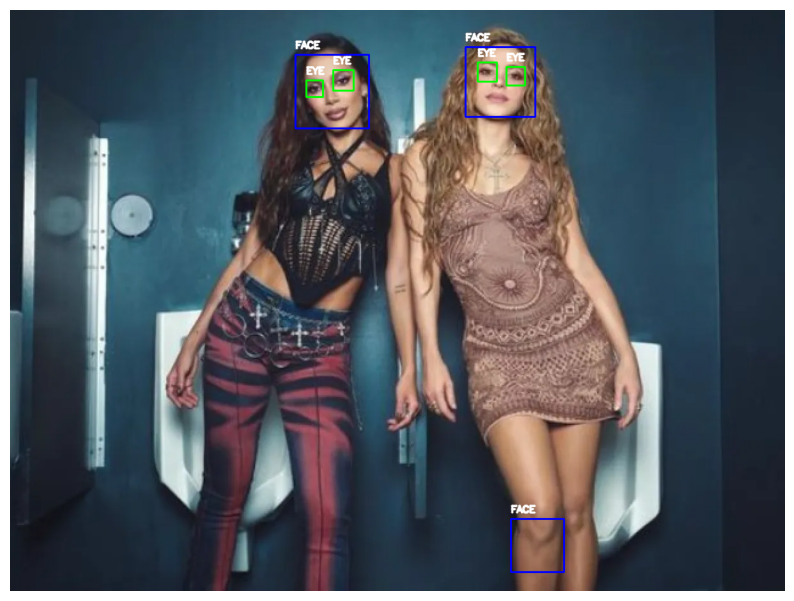

In [ ]:
# Carregar uma imagem como exemplo (substitua pelo caminho ou carregue seu próprio arquivo no Colab)
uploaded_file = "/content/anitta-shakira.jpg"  # Substitua por outro arquivo carregado no Colab
process_image(uploaded_file)